In [154]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

In [155]:
np.random.seed(0)

In [156]:
X,y = spiral_data(samples=100,classes=3)

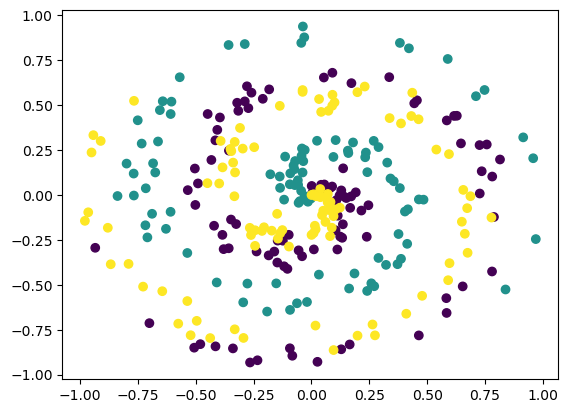

In [157]:
plt.scatter(X[:,0],X[:,1],c=y)

In [158]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward(self,inputs):
        self.output = np.dot(inputs,self.weights) + self.biases
        self.inputs = inputs
    
    def backward(self,dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        self.dinputs = np.dot(dvalues,self.weights.T)

In [159]:
# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
        keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
        keepdims=True)
        self.output = probabilities
    
    def backward(self,dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index,(single_output,single_dvalue) in enumerate(zip(self.output,dvalues)):
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalue)
            

In [160]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values we
        self.dinputs[self.inputs <= 0] = 0

In [161]:
class CrossEntropyLoss:
    def calculate(self,ypred,ytrue):
        ypred = np.clip(ypred,1e-7,1-1e-7)
        return np.mean(-np.log(ypred[range(len(ypred)),ytrue]))
    
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


In [162]:
class Activation_Softmax_CrossEntropy_loss:
   # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = CrossEntropyLoss()
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        

In [163]:
class SGD_Optimizer():
    def __init__(self,lr=0.1):
        self.lr = lr
    def update_params(self,layer):
        layer.weights -= self.lr * layer.dweights
        layer.biases -= self.lr * layer.dbiases
        
        

In [164]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2,64)

activation1 = Activation_ReLU()

dense2 = Layer_Dense(64,3)

loss_activation = Activation_Softmax_CrossEntropy_loss()

optimizer = SGD_Optimizer(lr=1)

In [169]:
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
        f'acc: {accuracy:.3f}, ' +
        f'loss: {loss:.3f}')
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)


epoch: 0, acc: 0.917, loss: 0.189
epoch: 100, acc: 0.913, loss: 0.203
epoch: 200, acc: 0.920, loss: 0.194
epoch: 300, acc: 0.917, loss: 0.252
epoch: 400, acc: 0.897, loss: 0.267
epoch: 500, acc: 0.927, loss: 0.187
epoch: 600, acc: 0.917, loss: 0.236
epoch: 700, acc: 0.923, loss: 0.176
epoch: 800, acc: 0.917, loss: 0.209
epoch: 900, acc: 0.937, loss: 0.159
epoch: 1000, acc: 0.917, loss: 0.185
epoch: 1100, acc: 0.863, loss: 0.428
epoch: 1200, acc: 0.907, loss: 0.263
epoch: 1300, acc: 0.917, loss: 0.245
epoch: 1400, acc: 0.793, loss: 0.776
epoch: 1500, acc: 0.923, loss: 0.162
epoch: 1600, acc: 0.923, loss: 0.245
epoch: 1700, acc: 0.923, loss: 0.179
epoch: 1800, acc: 0.920, loss: 0.179
epoch: 1900, acc: 0.933, loss: 0.187
epoch: 2000, acc: 0.920, loss: 0.186
epoch: 2100, acc: 0.917, loss: 0.195
epoch: 2200, acc: 0.930, loss: 0.189
epoch: 2300, acc: 0.933, loss: 0.159
epoch: 2400, acc: 0.920, loss: 0.187
epoch: 2500, acc: 0.887, loss: 0.343
epoch: 2600, acc: 0.923, loss: 0.177
epoch: 2700, 

In [185]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [186]:
X,y = make_blobs(n_samples=100,centers=2,random_state=0)

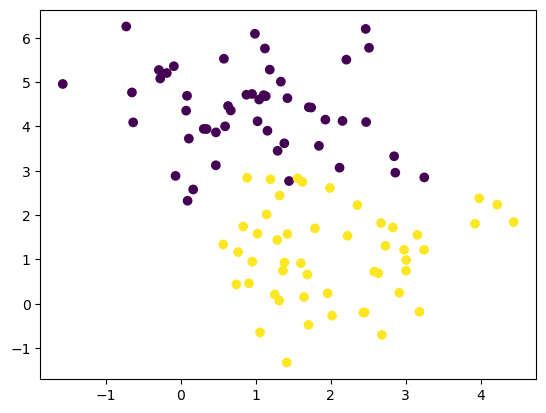

In [187]:
plt.scatter(X[:,0],X[:,1],c=y)

In [190]:
layer1 = Layer_Dense(2,16)
act = Activation_ReLU()
layer2 = Layer_Dense(16,2)
lossact = Activation_Softmax_CrossEntropy_loss()

for epoch in range(1001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = lossact.forward(layer2.output,y)
    
    if epoch % 100 == 0:
        predictions = np.argmax(lossact.output, axis=1)
        accuracy = np.mean(predictions==y)
        print(f"Epoch : {epoch} , Acc : {accuracy} , Loss : {loss}")
    
    lossact.backward(lossact.output,y)
    layer2.backward(lossact.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)
    
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)

Epoch : 0 , Acc : 0.25 , Loss : 0.6934518549160306
Epoch : 100 , Acc : 0.95 , Loss : 0.10024526711351506
Epoch : 200 , Acc : 0.95 , Loss : 0.09951252879747784
Epoch : 300 , Acc : 0.96 , Loss : 0.07518522531237175
Epoch : 400 , Acc : 0.95 , Loss : 0.0656728021819736
Epoch : 500 , Acc : 0.96 , Loss : 0.05599372965438323
Epoch : 600 , Acc : 0.99 , Loss : 0.04162883742056032
Epoch : 700 , Acc : 0.99 , Loss : 0.034824384962790146
Epoch : 800 , Acc : 0.95 , Loss : 0.08182288808500958
Epoch : 900 , Acc : 0.99 , Loss : 0.031324375908226336
Epoch : 1000 , Acc : 0.99 , Loss : 0.030397405652334654
